In [ ]:
import os
import pickle
import glob
import skimage
import skimage.transform
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import sys

sys.path.append('../functions')

import chirp_functions as proc
%matplotlib inline

: 

In [2]:
## STEP 1: PREPROCESS DATA
proc.preprocess_chirp(data_dir = '../../data/kagome-02.26.2022-center/raw/band_structure/', 
                       frequencies = np.linspace(1000, 18000, 426), 
                       targetfile = '../../data/kagome-02.26.2022-center/preprocessed/', 
                       title = 'scppos_', setno = 0)

Found 50 records
Preprocessing complete!


In [34]:
#correct phase

from tqdm import tqdm


freq_num = 500
freq_min = 2000
freq_max = 16000
freqs = np.array([(0, np.linspace(freq_min, freq_max, freq_num))], dtype=object)


filename = '../../data/chirp_kagome_centralSource_2-16kHz_0802/preprocessed/'


    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f)

            for point in real_data:
                if point[1] > 110:
                    point[3] = -point[3]
                    point[2] = -point[2]
            
            real_data.dump(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl')



100%|██████████| 500/500 [00:00<00:00, 2527.51it/s]


In [29]:
## 2D fourier transform

from tqdm import tqdm

folder = "../../data/kagome-01.15.2022-1transducer/"

with open(folder + "preprocessed/_10000.0_0.pkl",'rb') as f:
    real_data = pickle.load(f)

L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)
kxs = np.linspace(-3*kxmax, 3*kxmax, 150)
kys = np.linspace(-3*kymax, 3*kymax, 150)

reciprocal_data = np.zeros((len(kxs), len(kys)))
reciprocal_raw = np.zeros((len(kxs), len(kys)), dtype=complex)

    
'''
Elements of real_data are assumed to look like:
    0: X in mm
    1: Y in mm
    2: Amplitude
    3: Phase in degrees
'''

    
for yi in tqdm(range(len(kys))):
    for xi in range(len(kxs)):
        raw = np.array(
                [point[2] * np.exp(-1j * (kxs[xi] * (point[0]*10*np.sqrt(3)/4 / 1000) + kys[yi] * (point[1]*7.5 / 1000) + (point[3] / 57.2957795131))) 
                    for point in real_data]).sum()
        amplitude = np.abs(raw)
        reciprocal_data[yi][xi] = amplitude
        reciprocal_raw[yi][xi] = raw
        

100%|██████████| 150/150 [00:07<00:00, 19.97it/s]


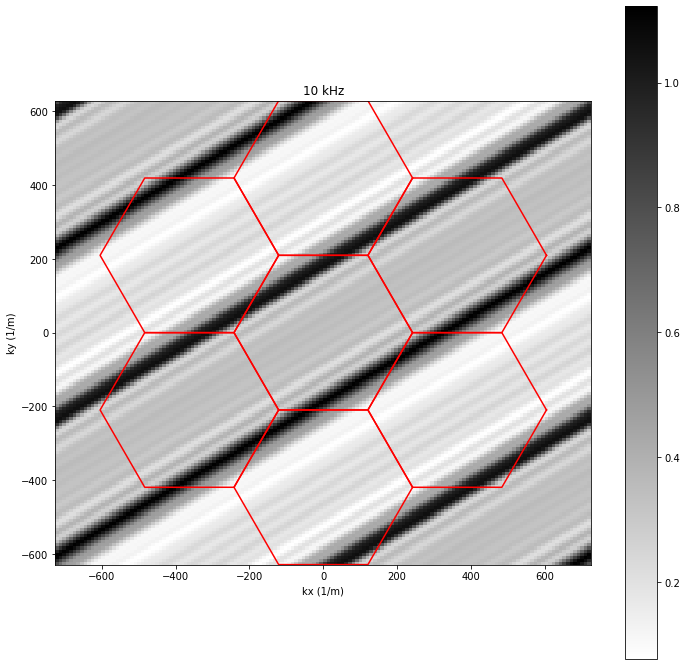

In [30]:
freq = 10
plt.figure(figsize=(12,12))
plt.imshow(reciprocal_data, cmap = 'binary', extent = [-3*kxmax, 3*kxmax, -3*kymax, 3*kymax], aspect = 'equal', origin = 'lower')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]

for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


plt.xlabel("kx (1/m)")
plt.ylabel("ky (1/m)")
plt.title(str(freq)+" kHz")
plt.colorbar()

plt.savefig(folder + "fourier/figures/2D_DFT_{}kHz.png".format(freq))





